

## 5-1. Variational Quantum Eigensolver (VQE) Algorithm

First, we introduce the VQE (Variational Quantum Eigensolver) algorithm, which is expected to be applied to material science and quantum chemistry. This algorithm is used to find the value of the ground energy of matter.

### Background

It is believed that the properties of molecules and matter are mostly determined by the motion of electrons in them. Therefore, by solving the Schrodinger equation, which is the equation governing electrons, (see [4-1](4.1_quantum_simulation.ipynb))

$$ H|\psi\rangle = E|\psi\rangle$$

 the properties of molecules and matter can be revealed by calculation. Here $H$ is an operator (matrix) called the Hamiltonian, which is determined by the details of the system, such as the shape of the molecules. As can be seen from the form $H|\psi\rangle = E|\psi\rangle$, solving the Schrodinger equation is equivalent to solving the eigenvalue problem for the Hamiltonian $H$ and finding the eigenvalues $E_i$ and the corresponding eigenvectors (also called eigenstates) $|\phi_i\rangle$. The eigenvalue $E_i$ is the energy of the eigenstate $|\phi_i\rangle$.

In chemistry, solving this problem is called **quantum chemical calculation**, and there is still active research on how to solve this problem. The problem becomes exponentially more difficult as the number of electrons increase, so that it is practically impossible to solve it exactly when the size of the molecule or the unit lattice of the crystal becomes large. Therefore, various approximate solutions are being studied. The difficulty of this problem is caused by the fact that $H$ is a matrix acting on the quantum state, and its dimension grows exponentially as the number of particles increases.

### Variational Methods
Unless we consider extreme environments, electrons are usually in the lowest energy state, i.e., the ground state. Therefore, among the eigenstates, the ground state is of particular interest.

The **variational method** is a powerful method for finding the ground state of a Hamiltonian of very large dimension. The variational method uses the fact that for any given state $|\psi\rangle$, its energy expectation value will always be higher than the ground energy $E_0$, i.e., 

$$\langle \psi|H|\psi\rangle \geq E_0$$

(This is also called the variational principle.) From this, if we bring many states $\{|\psi_i\rangle\}$ at random and find the state with the lowest energy among them, we would expect it to be the state closest to the ground state in $\{|\psi_i\rangle\}$.

In fact, if we were to bring states at random, the probability of finding a state close to the ground state would be exponentially small in relation to the size of the system. Therefore, the usual approach is to construct a parameterized quantum state $|\psi(\theta)\rangle$ (where $\theta$ is a parameter) based on physical and chemical intuition and experience, and find the $\theta$ that minimizes

$$\langle \psi(\theta)|H|\psi(\theta)\rangle$$

For the convenience of performing calculations on a classical computer, it has been necessary to select a quantum state $|\psi(\theta)\rangle$  that can be efficiently described by a classical computer.

### What is VQE?

VQE is **an algorithm that searches for ground states using quantum states that can be efficiently described by a quantum computer.**

### Variational Methods

The algorithm is as follows:

1. generate a quantum state $|\psi(\theta)\rangle$ on a quantum computer.

2. measure $\langle H(\theta)\rangle = \langle \psi(\theta)|H|\psi(\theta)\rangle$ 

3. Based on the measurement results, determine the $\theta$ such that $\langle \psi(\theta)|H|\psi(\theta)\rangle$ becomes smaller using a classical computer.

This is repeated until $\langle\psi(\theta)|H|\psi(\theta)\rangle$ converges to obtain an approximate ground state.  

! [VQE-concept](figs/5/VQE_concept.png)

(Figure cited from reference [1])

### Example Implementation

Below is an example implementation of VQE using numpy. (Of course, it can be easily implemented in QURI Parts as well, so readers who can afford to do so are encouraged to try.)   
Here we find the ground energy of H-He$^+$ (helium hydride ion). We will use two qubits and implement them according to reference [1].

### Preparation of quantum gates

In [2]:
import numpy as np
nqubits = 2
### Prepare the Pauli operator.
pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
pHad = (pX+pZ)/np.sqrt(2)
pP0 = (pI+pZ)/2
pP1 = (pI-pZ)/2

In [3]:
#Convert the Pauli operator into a single quantum gate.
X=[1]*(nqubits)
Y=[1]*(nqubits)
Z=[1]*(nqubits)
H=[1]*(nqubits)
P0=[1]*(nqubits)
P1=[1]*(nqubits)

for i in range(nqubits):
    for j in range(nqubits):
        if(i != j):
            X[i] = np.kron(pI,X[i])
            Y[i] = np.kron(pI,Y[i])
            Z[i] = np.kron(pI,Z[i])
            H[i] = np.kron(pI,H[i])
            P0[i] = np.kron(pI,P0[i])
            P1[i] = np.kron(pI,P1[i])
        else:
            X[i] = np.kron(pX,X[i])
            Y[i] = np.kron(pY,Y[i])
            Z[i] = np.kron(pZ,Z[i])
            H[i] = np.kron(pHad,H[i])
            P0[i] = np.kron(pP0,P0[i])
            P1[i] = np.kron(pP1,P1[i])
Ide = np.eye(2**nqubits)

In [4]:
#2 prepare quantum gate
CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
CX = [[0 for i in range(nqubits)] for j in range(nqubits)]

for i in range(nqubits):
    for j in range(nqubits):
        CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
        CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))

In [5]:
#Prepare variational quantum gates (gates that allow specifying the angle of rotation with respect to X,Y,Z).

from scipy.linalg import expm
def RX(target,angle):
    return expm(-0.5*angle*1.j*X[target])
def RY(target,angle):
    return expm(-0.5*angle*1.j*Y[target])
def RZ(target,angle):
    return expm(-0.5*angle*1.j*Z[target])

In [6]:
#Prepare initial state|0000...0>.
def StateZeros(nqubits):
    State = np.zeros(2**nqubits)
    State[0]=1
    return State

### Prepare the Hamiltonian.

Based on reference [1] [Supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fncomms5213/MediaObjects/41467_2014_BFncomms5213_MOESM1050_ESM.pdf), define the coefficients of the Hamiltonian when the distance between H and He is $0.9$ angstroms. By finding the minimum energy eigenstates of this Hamiltonian, we can determine the properties of various H-He$^+$ molecules.

※ This Hamiltonian is derived from the magnitude of the electron-nucleus Coulomb interaction and the Coulomb interaction between electrons. The details will be studied in the section on quantum chemical calculations in Chapter 6.

In [8]:
M = (-3.8505 * Ide  - 0.2288 * X[1] - 1.0466 * Z[1] - 0.2288 * X[0] +  0.2613 * np.dot(X[0],X[1]) + \
     0.2288 *np.dot(X[0],Z[1]) - 1.0466*Z[0] + 0.2288* np.dot(Z[0],X[1]) +  0.2356 * np.dot(Z[0],Z[1]) )/2

### Preparing a quantum circuit

Implement a variational quantum circuit in exactly the same form as in the paper as follows.

In [14]:
n_param = 6
def TwoQubitPQC(phi):
    state = StateZeros(2)
    state = np.dot(RX(0,phi[0]),state)
    state = np.dot(RZ(0,phi[1]),state)
    state = np.dot(RX(1,phi[2]),state)
    state = np.dot(RZ(1,phi[3]),state)
    state = np.dot(CX[1][0],state)
    state = np.dot(RZ(1,phi[4]),state)
    state = np.dot(RX(1,phi[5]),state)
    return state

### Measuring the expected energy of a quantum state

Define a function to calculate the energy expectation value of the output by the variational quantum circuit as follows.

In [1]:
#Convert a column vector to a row vector
def ExpectVal(Operator,State):
    BraState = np.conjugate(State.T) 
#Cross a matrix with a column vector and a row vector
    tmp = np.dot(BraState,np.dot(Operator,State)) 
#the real part of an element
    return np.real(tmp) 

### Minimizing the energy expectation value
The Powell method implemented in `scipy.optimize.minimize` is one of the optimization methods that do not use gradient information. The initial values of the parameters are specified randomly.

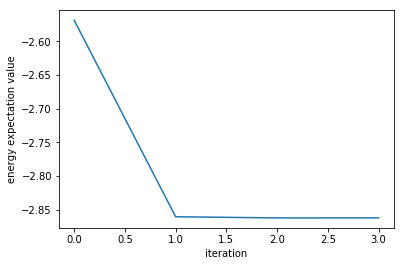

In [32]:
import scipy.optimize
import matplotlib.pyplot as plt

def cost(phi):
    return ExpectVal(M, TwoQubitPQC(phi))

cost_val = [] 
#function to preserve changes in the cost function

#This function is called for each iteration.
def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

init = np.random.rand(n_param)
callback(init)
res = scipy.optimize.minimize(cost, init, 
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

Let`s verify if the values calculated by VQE are correct by comparing them with the exact energy obtained by diagonalizing the Hamiltonian.

In [23]:
import scipy.linalg
l, P = scipy.linalg.eigh(M)
print(l[0])  #minimum eigenvalue
print(cost(res.x)) #VQE result

-2.8626207640766816
-2.8623984117519257


Although not identical to the eigenvalues calculated by the Powell method, they are the same to three decimal places, so we can say that we have an almost correct value.　

Next, let us examine the case where noise exists at the output of the circuit. NISQ cannot avoid errors (noise) in the output, so it is very important to verify whether the algorithm works even with noise and how much noise it can withstand.

In [24]:
def cost(phi):
    return ExpectVal(M,TwoQubitPQC(phi))+np.random.normal(0,0.01)

def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

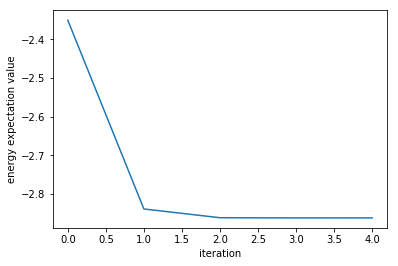

-2.862398401331204


In [34]:
cost_val=[]
#history of cost function
init = np.random.rand(6)
callback(init)
res = scipy.optimize.minimize(cost, init,
                              method='Powell',
                              callback=callback)
plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()
print(cost(res.x))

If the noise is small, it is clear that the optimization can be performed in almost the same way. (Interested readers are encouraged to experiment with higher noise levels.)

### Reference 

[1] A. Peruzzo _et al_. , “A variational eigenvalue solver on a photonic quantum processor“ [Nat. Commun. 5:4213 doi: 10.1038/ncomms5213 (2014)](https://www.nature.com/articles/ncomms5213) 